# A time-varying PDE with Neumann conditions

The immersed-layer heat equation is

$$\dfrac{\partial \overline{T}}{\partial t} = \kappa \nabla^2 \overline{T} - \kappa \nabla\cdot \delta(\chi) \mathbf{n} [T] + \delta(\chi) [q] + q''$$

where $[q] = q^+_b - q^-_b = -\kappa (\partial T^+/\partial n - \partial T^-/\partial n)$ and $[T] = T_b^+ - T_b^-$. It is important to note that, collectively,

$$\kappa \nabla^2 \overline{T} - \kappa \nabla\cdot \delta(\chi) \mathbf{n} [T] + \delta(\chi) [q]$$

represents a modified version of the Laplacian operator: the second and third term "fix" the differencing of the first term across the discontinuity, replacing the values of $\overline{T}$ across this discontinuity with the correct boundary values and boundary derivatives.

The Neumann boundary condition is

$$-\kappa \mathbf{n} \delta^{T}(\chi)\cdot \nabla \overline{T} + \kappa \mathbf{n} \delta^T(\chi)\cdot\delta(\chi) \mathbf{n} [T] = \frac{1}{2} (q_b^+ + q_b^-)$$

where $q_b^\pm$ are the heat fluxes through the immersed surface, e.g. $q_b^+ = -\kappa \partial T^+/\partial n$. The second term on the left side corrects the gradient of the masked temperature field $\overline{T}$, replacing the temperatures in this field across the discontinuity with the correct boundary values.

When we discretize spatially, we introduce $L$ for the Laplacian, $D$ and $G$ for divergence and gradient, respectively. Also, for shorthand let us denote $R$ for $\delta(\chi)$, and denote $R_n$ for the discrete version of $\delta(\chi)\mathbf{n}$, acting on surface scalars and regularizing them (multiplied by normal vectors) to a vector field on the grid. The transpose of this is $R_n^T$, the discrete version of $\mathbf{n} \delta^{T}(\chi)\cdot$.

So we can write the discrete equations for $\overline{T}$ and $[T]$ as

$$\frac{\mathrm{d} \overline{T}}{\mathrm{d} t} -\kappa L \overline{T} + \kappa DR_n [T] = q + R[q]$$
$$-\kappa R_n^T G \overline{T} + \kappa R_n^TR_n [T] = \overline{q}$$

The matrix form is

$$\begin{bmatrix}
\mathcal{L}_C^\kappa & \kappa D_s \\ -\kappa G_s & \kappa R_n^TR_n
\end{bmatrix}\begin{pmatrix}
T \\ [T]
\end{pmatrix} =
\begin{pmatrix}
q + R [q] \\ (q^+_b + q^-_b)/2
\end{pmatrix}$$

It is crucial that the time marching for solving this problem has a consistent time level
among all terms in the "modified" Laplacian. In other words, if the Laplacian term is
treated implicitly, then the other two terms must be, as well.

In [1]:
using ImmersedLayers
using Plots
using UnPack

## Set up the constrained ODE system operators
The problem type is generated with the usual macro call. In this example,
we will make use of more of the capabilities of the resulting problem
constructor for "packing" it with information about the problem.

In [2]:
@ilmproblem NeumannHeatConduction scalar

The function below implements the term $R[q]$. As we mentioned before, this term
must be treated at the same time level as the Laplacian term. Thus, we
designate this as part of the "implicit" part of the RHS.

Since $[q]$ is a known term, this function only depends on time. It could also
depend on an auxiliary state, `x`, but that isn't used here.

In [3]:
function heatconduction_ode_implicit_rhs!(dT,x,sys::ILMSystem,t)
    @unpack bc, forcing, phys_params, extra_cache, base_cache = sys
    @unpack dqbtmp = extra_cache

    fill!(dT,0.0)
    fill!(dqbtmp,0.0)
    # Calculate the single-layer term on the RHS
    prescribed_surface_jump!(dqbtmp,x,t,sys)
    regularize!(dT,dqbtmp,sys)

    return dT
end

heatconduction_ode_implicit_rhs! (generic function with 1 method)

We also have an explicit part of the RHS, one that potentially
depends on the field itself. Here, it does not, but simply implements
the volumetric heating function, $q''$.

In [4]:
function heatconduction_ode_explicit_rhs!(dT,T,x,sys::ILMSystem,t)
    @unpack extra_cache, base_cache, phys_params = sys
    @unpack fcache, Ttmp = extra_cache

    fill!(dT,0.0)
    # Compute the contribution from the forcing models to the right-hand side
    apply_forcing!(dT,T,t,fcache,phys_params)

    return dT
end

heatconduction_ode_explicit_rhs! (generic function with 1 method)

Now, we create the function that calculates the RHS of the boundary condition.
For this Neumann condition, we simply take the average of the interior
and exterior prescribed heat flux values. The first argument `dqb` holds the result.
Again, `x` isn't used here.

In [5]:
function heatconduction_bc_rhs!(dqb,x,sys::ILMSystem,t)
    fill!(dqb,0.0)
    prescribed_surface_average!(dqb,x,t,sys)
    return dqb
end

heatconduction_bc_rhs! (generic function with 1 method)

This function calculates the (negative of the) contribution to $dT/dt$ from the Lagrange
multiplier (the input `Tjump`, which represents $[T]$). This term is $\kappa D_s [T]$.

In [6]:
function heatconduction_constraint_force!(dT,Tjump,x,sys::ILMSystem)
    @unpack phys_params = sys
    κ = phys_params["diffusivity"]
    fill!(dT,0.0)
    surface_divergence!(dT,κ*Tjump,sys)
    return dT
end

heatconduction_constraint_force! (generic function with 1 method)

Now, we provide the transpose term of the previous function for the left hand side of
the constraint equation: a function that computes the surface gradient operation,
 $-\kappa G_s \overline{T}$. The first argument `dqb` holds the result.

In [7]:
function heatconduction_bc_op!(dqb,T,x,sys::ILMSystem)
    @unpack phys_params = sys
    κ = phys_params["diffusivity"]
    fill!(dqb,0.0)
    surface_grad!(dqb,T,sys)
    dqb .*= -κ
    return dqb
end

heatconduction_bc_op! (generic function with 1 method)

This last operator computes the final left-hand-side operation of the constraint equations,
taking the Lagrange multiplier (the jump in surface temperature), and computing $\kappa R_n^T R_n [T]$.

In [8]:
function heatconduction_bc_reg!(dqb,Tjump,x,sys::ILMSystem)
    @unpack extra_cache, phys_params = sys
    @unpack Ttmp, vtmp = extra_cache
    κ = phys_params["diffusivity"]

    fill!(vtmp,0.0)
    fill!(dqb,0.0)
    regularize_normal!(vtmp,κ*Tjump,sys)
    normal_interpolate!(dqb,vtmp,sys)

    return dqb
end

heatconduction_bc_reg! (generic function with 1 method)

## Set up the extra cache and extend `prob_cache`
Here, we construct an extra cache that holds a few extra intermediate
variables, used in the routines above. But this cache also, crucially, holds
the functions and operators of the constrained ODE function. We call
the function `ODEFunctionList` to assemble these together.

In [9]:
struct NeumannHeatConductionCache{GT,GVT,DTT,FRT,FT} <: AbstractExtraILMCache
   Ttmp :: GT
   vtmp :: GVT
   dqbtmp :: DTT
   fcache :: FRT
   f :: FT
end

function ImmersedLayers.prob_cache(prob::NeumannHeatConductionProblem,
                                   base_cache::BasicILMCache{N,scaling}) where {N,scaling}
    @unpack phys_params, forcing = prob
    @unpack gdata_cache, g = base_cache

    Ttmp = zeros_grid(base_cache)
    vtmp = zeros_gridgrad(base_cache)
    dqbtmp = zeros_surface(base_cache)

    # Construct a Lapacian outfitted with the diffusivity
    κ = phys_params["diffusivity"]
    heat_L = Laplacian(base_cache,κ)

    # Create cache for the forcing regions
    fcache = ForcingModelAndRegion(forcing["heating models"],base_cache)


    # State (grid temperature data) and constraint (surface Lagrange multipliers)
    f = ODEFunctionList(state = zeros_grid(base_cache),
                        constraint = zeros_surface(base_cache),
                        ode_rhs=heatconduction_ode_explicit_rhs!,
                        lin_op=heat_L,
                        bc_rhs=heatconduction_bc_rhs!,
                        constraint_force = heatconduction_constraint_force!,
                        bc_op = heatconduction_bc_op!,
                        bc_regulator = heatconduction_bc_reg!,
                        ode_implicit_rhs=heatconduction_ode_implicit_rhs!)

    NeumannHeatConductionCache(Ttmp,vtmp,dqbtmp,fcache,f)
end

We define the same timestep function as in the Dirichlet problem

In [10]:
function timestep_fourier(u,sys)
    @unpack phys_params = sys
    g = get_grid(sys)
    κ = phys_params["diffusivity"]
    Fo = phys_params["Fourier"]
    Δt = Fo*cellsize(g)^2/κ
    return Δt
end

timestep_fourier (generic function with 1 method)

## Solve the problem
We will solve heat conduction inside a square region with thermal diffusivity equal to 1.
We will apply heating through the boundary and also introduce two different
types of area heating regions in the interior.

### Set up the grid

In [11]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

### Set up the body shape.
Here, we will demonstrate the solution on a circular shape of radius 1.

In [12]:
Δs = 1.4*cellsize(g)
body = Square(1.0,Δs);

Stationary body

In [13]:
X = MotionTransform([0,0],0)
joint = Joint(X)
m = RigidBodyMotion(joint,body)
x = zero_motion_state(body,m)
update_body!(body,x,m)

Closed polygon with 4 vertices and 572 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Specify the physical parameters, data, etc.
These can be changed later without having to regenerate the system.

Here, we create a dict with physical parameters to be passed in.

In [14]:
phys_params = Dict("diffusivity" => 1.0,
                    "Fourier" => 1.0,
                    "areaheater_flux" => 10.0,
                    "areaheater_freq" => 1.0,
                     "areaheater_temp" => 1.0,
                     "areaheater_coeff" => 10.0)

Dict{String, Float64} with 6 entries:
  "areaheater_coeff" => 10.0
  "Fourier"          => 1.0
  "areaheater_temp"  => 1.0
  "diffusivity"      => 1.0
  "areaheater_freq"  => 1.0
  "areaheater_flux"  => 10.0

Define the heating region functions. We will create one heating region
with prescribed heat flux and another with a target temperature

In [15]:
fregion1 = Circle(0.2,1.4*Δx)
tr1 = MotionTransform((0.0,-0.7),0.0)
update_body!(fregion1,tr1)

function model1!(σ,T,t,fr::AreaRegionCache,phys_params)
    σ .= phys_params["areaheater_flux"]
end
afm1 = AreaForcingModel(fregion1,model1!)

fregion2 = Circle(0.2,1.4*Δx)
tr2 = RigidTransform((-0.7,0.7),0.0)
update_body!(fregion2,tr2)

function model2!(σ,T,t,fr::AreaRegionCache,phys_params)
    f = phys_params["areaheater_freq"]
    T0 = phys_params["areaheater_temp"]
    h = phys_params["areaheater_coeff"]
    σ .= h*(T0 - T)
end
afm2 = AreaForcingModel(fregion2,model2!);

Plot the heating regions

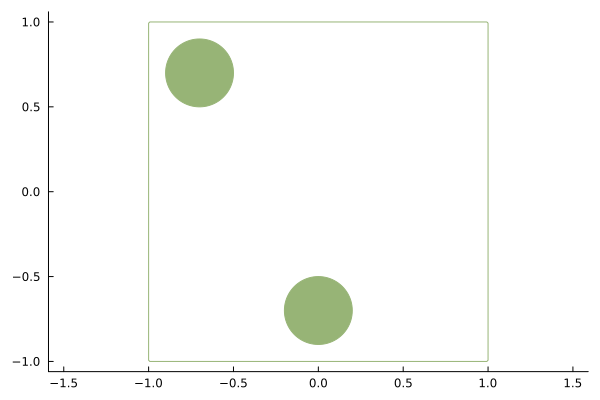

In [16]:
plot(body,fill=false)
plot!(fregion1)
plot!(fregion2)

Pack them together

In [17]:
forcing_dict = Dict("heating models" => AbstractForcingModel[afm1,afm2])

Dict{String, Vector{AbstractForcingModel}} with 1 entry:
  "heating models" => [AreaForcingModel{Ellipse{88}, Pairs{Symbol, Union{}, Tup…

The heat flux boundary functions on the exterior and interior are
defined here and assembled into a dict. Note that we are using the $x$
component of the normal for the interior boundary heat flux. This sets
non-zero heat fluxes through the vertical boundaries (inward on the left,
outward on the right), and adiabatic conditions on the top and bottom.

In [18]:
function get_qbplus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbplus = zeros_surface(base_cache)
    return qbplus
end

function get_qbminus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbminus = zeros_surface(base_cache)
    qbminus .= nrm.u
    return qbminus
end

bcdict = Dict("exterior" => get_qbplus,"interior" => get_qbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_qbminus
  "exterior" => get_qbplus

Construct the problem, passing in the data and functions we've just
created. We pass in the body's motion (however trivial) via the
`motions` keyword.

In [19]:
prob = NeumannHeatConductionProblem(g,body,scaling=GridScaling,
                                             phys_params=phys_params,
                                             bc=bcdict,
                                             motions=m,
                                             forcing=forcing_dict,
                                             timestep_func=timestep_fourier);

Construct the system

In [20]:
sys = construct_system(prob);

### Solving the problem
Set an initial condition. Here, we just get an initial (zeroed) copy of the
solution prototype that we have stored in the extra cache. We also
get the time step size for our own inspection.

In [21]:
u0 = init_sol(sys)

(Primal nodes in a (nx = 408, ny = 410) cell grid of type Float64 data
  Number of Primal nodes: (nx = 407, ny = 409), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

Now, create the integrator, with a time interval of 0 to 1. This uses the `HETrapezoidalAB2()`
method, by default, since it has a constraint that depends on the
Lagrange multipliers.

In [22]:
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 408, ny = 410) cell grid of type Float64 data
  Number of Primal nodes: (nx = 407, ny = 409), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

Now advance the solution by 0.01 convective time units, by using the `step!` function,
which steps through the solution.

In [23]:
step!(integrator,0.01)

### Plot the solution
First, create the temperature function that allows us to easily plot.

In [24]:
temperature(T,σ,x,sys::ILMSystem,t) = T
@snapshotoutput temperature

Now plot

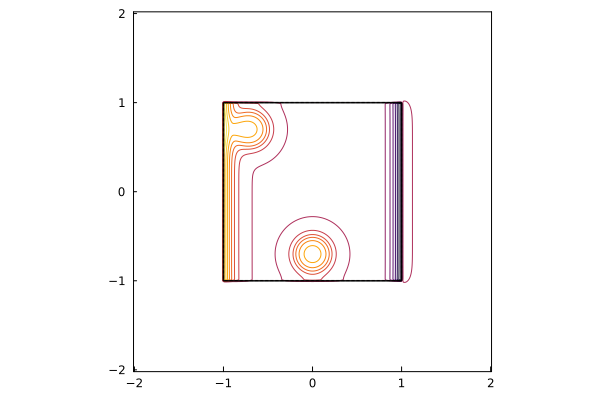

In [25]:
plot(temperature(integrator),sys)

and the Lagrange multiplier (the constraint)

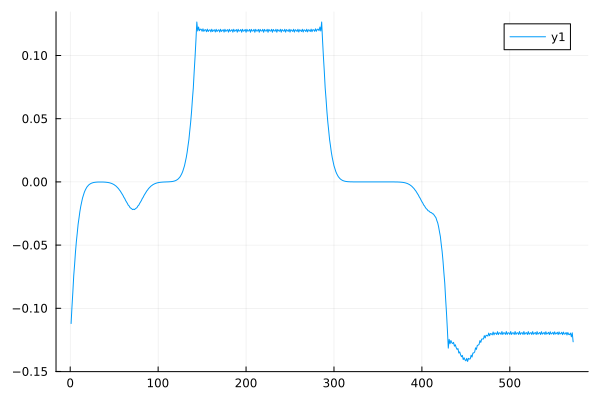

In [26]:
plot(constraint(integrator.u))

Plot a slice across the domain. To do so, we make use
of the `interpolatable_field` function, which creates a functional version
of the temperature field that we can access like a spatial field, e.g. $T(x,y)$.

In [27]:
Tfcn = interpolatable_field(temperature(integrator),sys);

First, a vertical slice along $x=0$, to verify that the adiabatic conditions
are met there.

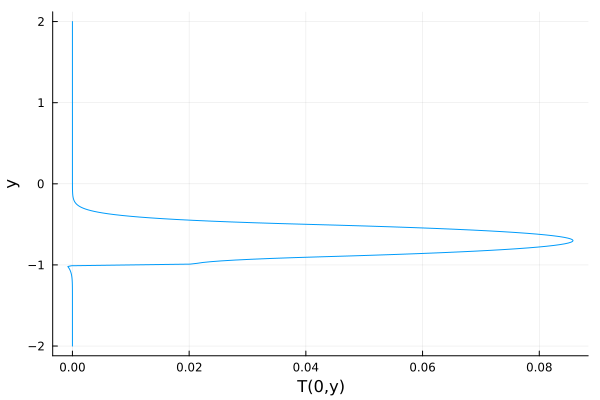

In [28]:
y = -2:0.01:2
plot(Tfcn(0,y),y,xlabel="T(0,y)",ylabel="y",legend=false)

Now, a horizontal slice along $y=0$, to verify that the adiabatic conditions
are met there.

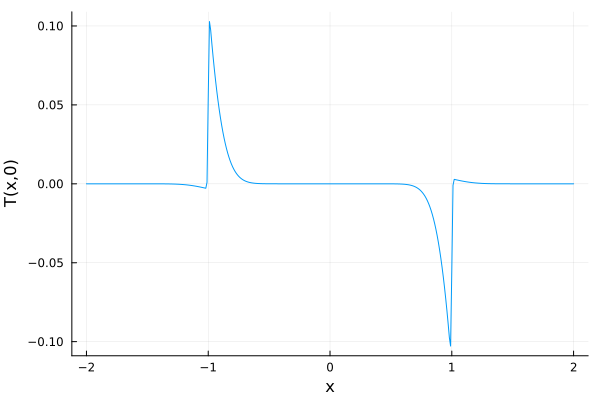

In [29]:
x = -2:0.01:2
plot(x,Tfcn(x,0),xlabel="x",ylabel="T(x,0)",legend=false)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*